In [1]:
import torch
from torch.sparse import to_sparse_semi_structured, SparseSemiStructuredTensor
from torch.utils.benchmark import Timer
SparseSemiStructuredTensor._FORCE_CUTLASS = True

In [2]:
from collections import defaultdict
import matplotlib.pyplot as plt

In [3]:
torch.cuda.set_device(1)

## Single Layer Test

In [22]:
batch_sizes = [4, 8 , 16, 32, 64, 128]
sizes = [384, 768, 1024, 1280]
dense_results = defaultdict(list)
sparse_results = defaultdict(list)
for size in sizes:
    for batch_size in batch_sizes:
        # mask Linear weight to be 2:4 sparse
        mask = torch.Tensor([0, 0, 1, 1]).tile((size, size)).cuda().bool()
        linear = torch.nn.Linear(size*4, size).half().cuda().eval()
        linear.weight = torch.nn.Parameter(mask * linear.weight)

        patch = 197 if size != 1280 else 257
        x = torch.rand(batch_size, patch, size*4).half().cuda()

        with torch.inference_mode():
            dense_output = linear(x)
            dense_t = Timer(stmt="linear(x)",
                            globals={"linear": linear,
                                    "x": x}).blocked_autorange().median * 1e3

            # accelerate via SparseSemiStructuredTensor
            linear.weight = torch.nn.Parameter(to_sparse_semi_structured(linear.weight))

            sparse_output = linear(x)
            sparse_t = Timer(stmt="linear(x)",
                            globals={"linear": linear,
                                    "x": x}).blocked_autorange().median * 1e3

            dense_results[size].append(dense_t)
            sparse_results[size].append(sparse_t)
            # sparse and dense matmul are numerically equivalent
            assert torch.allclose(sparse_output, dense_output, atol=1e-3)
            print(f"Dim: {size}, Bsz: {batch_size}")
            print(f"Dense: {dense_t:.3f}ms Sparse: {sparse_t:.3f}ms | Speedup: {(dense_t / sparse_t):.3f}x")
            

Dim: 384, Bsz: 4
Dense: 0.030ms Sparse: 0.071ms | Speedup: 0.415x
Dim: 384, Bsz: 8
Dense: 0.041ms Sparse: 0.068ms | Speedup: 0.610x
Dim: 384, Bsz: 16
Dense: 0.067ms Sparse: 0.068ms | Speedup: 0.987x
Dim: 384, Bsz: 32
Dense: 0.106ms Sparse: 0.063ms | Speedup: 1.694x
Dim: 384, Bsz: 64
Dense: 0.211ms Sparse: 0.122ms | Speedup: 1.735x
Dim: 384, Bsz: 128
Dense: 0.422ms Sparse: 0.239ms | Speedup: 1.767x
Dim: 768, Bsz: 4
Dense: 0.062ms Sparse: 0.076ms | Speedup: 0.817x
Dim: 768, Bsz: 8
Dense: 0.129ms Sparse: 0.094ms | Speedup: 1.373x
Dim: 768, Bsz: 16
Dense: 0.205ms Sparse: 0.181ms | Speedup: 1.132x
Dim: 768, Bsz: 32
Dense: 0.409ms Sparse: 0.227ms | Speedup: 1.803x
Dim: 768, Bsz: 64
Dense: 0.814ms Sparse: 0.451ms | Speedup: 1.805x
Dim: 768, Bsz: 128
Dense: 1.537ms Sparse: 0.849ms | Speedup: 1.811x
Dim: 1024, Bsz: 4
Dense: 0.138ms Sparse: 0.100ms | Speedup: 1.374x
Dim: 1024, Bsz: 8
Dense: 0.170ms Sparse: 0.194ms | Speedup: 0.876x
Dim: 1024, Bsz: 16
Dense: 0.407ms Sparse: 0.308ms | Speedup: 1.3

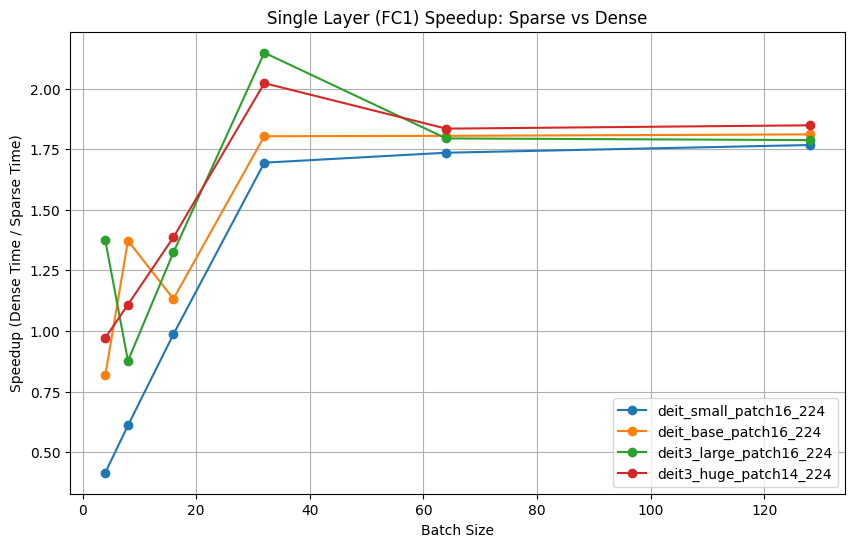

In [25]:
import numpy as np
# Calculating speedup: dense divided by sparse
speedup_results = defaultdict(list)

for dim in sizes:
    dense_times = np.array(dense_results[dim])
    sparse_times = np.array(sparse_results[dim])
    speedup = dense_times / sparse_times # Calculate speedup
    speedup_results[dim] = speedup.tolist()

# Plotting the speedup
plt.figure(figsize=(10, 6))

models = ['deit_small_patch16_224', 'deit_base_patch16_224', 'deit3_large_patch16_224', 'deit3_huge_patch14_224']
i = 0

for dim, speedup in speedup_results.items():
    plt.plot(batch_sizes, speedup, marker='o', label=f'{models[i]}')
    i += 1

plt.title('Single Layer (FC1) Speedup: Sparse vs Dense')
plt.xlabel('Batch Size')
plt.ylabel('Speedup (Dense Time / Sparse Time)')
plt.legend()
plt.grid(True)
plt.show()

In [20]:
import timm
def test_end_to_end(model_name, batch_size):
    # Create Sparse Model
    sparse_model = timm.create_model(model_name, pretrained=True)
    sparse_model.half().cuda().eval()
    for name, m in sparse_model.named_modules():
        if isinstance(m, torch.nn.Linear):
            if 'head' in name:
                continue
            weight_shape = m.weight.shape
            assert weight_shape[1] % 4 == 0
            mask = torch.Tensor([0, 0, 1, 1]).tile((weight_shape[0], int(weight_shape[1]/4))).cuda().bool()
            m.weight = torch.nn.Parameter(to_sparse_semi_structured(mask * m.weight))

    # Create Dense Model
    dense_model = timm.create_model(model_name, pretrained=True)
    dense_model.half().cuda().eval()
    for name, m in dense_model.named_modules():
        if isinstance(m, torch.nn.Linear):
            if 'head' in name:
                continue
            weight_shape = m.weight.shape
            assert weight_shape[1] % 4 == 0
            mask = torch.Tensor([0, 0, 1, 1]).tile((weight_shape[0], int(weight_shape[1]/4))).cuda().bool()
            m.weight = torch.nn.Parameter(mask * m.weight)
            
    x = torch.rand(batch_size, 3, 224, 224).half().cuda()
    with torch.inference_mode():
        dense_output = dense_model(x)
        dense_t = Timer(stmt="dense(x)",
                        globals={"dense": dense_model,
                                "x": x}).blocked_autorange().median * 1e3

        # accelerate via SparseSemiStructuredTensor

        sparse_output = sparse_model(x)
        sparse_t = Timer(stmt="sparse(x)",
                        globals={"sparse": sparse_model,
                                "x": x}).blocked_autorange().median * 1e3

        # sparse and dense matmul are numerically equivalent
        #assert torch.allclose(sparse_output, dense_output, atol=1e-3)
        print(f"Model: {model_name}, Batch Size: {batch_size}")
        print(f"Dense: {dense_t:.3f}ms Sparse: {sparse_t:.3f}ms | Speedup: {(dense_t / sparse_t):.3f}x")
    
    return dense_t, sparse_t
    

In [21]:
models = ['deit_small_patch16_224', 'deit_base_patch16_224', 'deit3_large_patch16_224', 'deit3_huge_patch14_224']
batch_sizes = [4, 8 , 16, 32, 64, 128]
dense_results = defaultdict(list)
sparse_results = defaultdict(list)
for model_name in models :
    for batch_size in batch_sizes:
        torch.cuda.empty_cache()
        dense_t, sparse_t = test_end_to_end(model_name=model_name, batch_size=batch_size)
        dense_results[model_name].append(dense_t)
        sparse_results[model_name].append(sparse_t)

Model: deit_small_patch16_224, Batch Size: 4
Dense: 3.873ms Sparse: 8.673ms | Speedup: 0.447x
Model: deit_small_patch16_224, Batch Size: 8
Dense: 4.191ms Sparse: 8.992ms | Speedup: 0.466x
Model: deit_small_patch16_224, Batch Size: 16
Dense: 4.430ms Sparse: 8.333ms | Speedup: 0.532x
Model: deit_small_patch16_224, Batch Size: 32
Dense: 6.501ms Sparse: 7.606ms | Speedup: 0.855x
Model: deit_small_patch16_224, Batch Size: 64
Dense: 12.103ms Sparse: 14.506ms | Speedup: 0.834x
Model: deit_small_patch16_224, Batch Size: 128
Dense: 25.563ms Sparse: 28.004ms | Speedup: 0.913x
Model: deit_base_patch16_224, Batch Size: 4
Dense: 4.079ms Sparse: 9.059ms | Speedup: 0.450x
Model: deit_base_patch16_224, Batch Size: 8
Dense: 5.594ms Sparse: 8.993ms | Speedup: 0.622x
Model: deit_base_patch16_224, Batch Size: 16
Dense: 10.146ms Sparse: 12.051ms | Speedup: 0.842x


KeyboardInterrupt: 

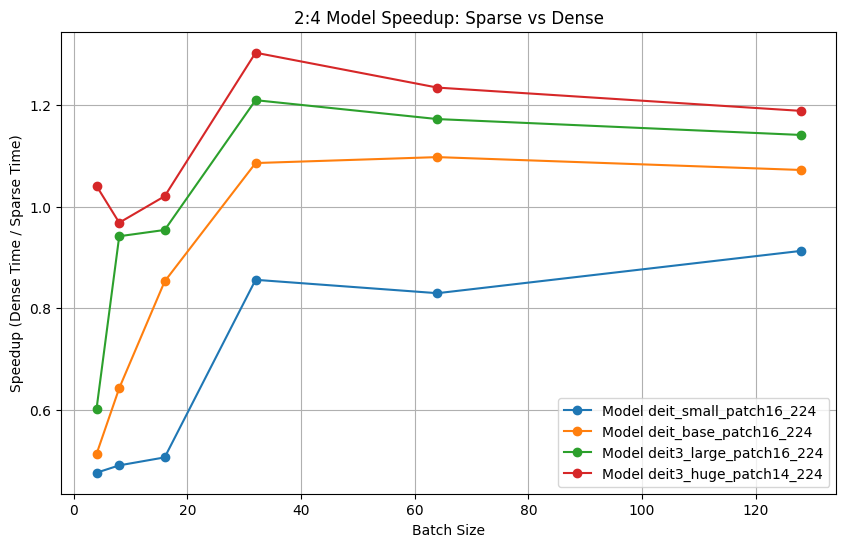

In [ ]:
import numpy as np
# Calculating speedup: dense divided by sparse
speedup_results = defaultdict(list)

for model in models:
    dense_times = np.array(dense_results[model])
    sparse_times = np.array(sparse_results[model])
    speedup = dense_times / sparse_times # Calculate speedup
    speedup_results[model] = speedup.tolist()

# Plotting the speedup
plt.figure(figsize=(10, 6))

for model, speedup in speedup_results.items():
    plt.plot(batch_sizes, speedup, marker='o', label=f'Model {model}')

plt.title('2:4 Model Speedup: Sparse vs Dense')
plt.xlabel('Batch Size')
plt.ylabel('Speedup (Dense Time / Sparse Time)')
plt.legend()
plt.grid(True)
plt.show()

In [19]:
raw_data = [1, 2, 3, 4, 1, 1, 2, 275, 279]
memory_photon = [ [0] * 8 for _ in range(16)]
memory_number = [ [0] * 8 for _ in range(16)]

for photon in raw_data:
    idx = photon // 256
    print(f'photon {photon}, photon // 256 = {idx}')
    # memory not full
    # save myself
    if memory_number[idx][-1] == 0 and photon not in memory_photon[idx]:
        memory_photon[idx] = [photon] + memory_photon[idx][:-1]
        memory_number[idx] = [1] + memory_number[idx][:-1]
        print(f'photon: {memory_photon}')
        print(f'number: {memory_number}')
    elif photon in memory_photon[idx]:
        # update myself
        memory_number[idx][memory_photon[idx].index(photon)] *= 2
        print(f'photon: {memory_photon}')
        print(f'number: {memory_number}')
    

photon 1, photon // 256 = 0
photon: [[1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0]]
number: [[1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0]]
photon 2, photon // 256 = 0
photon: [[2, 1, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 

In [12]:
memory_photon = [ [0] * 8 for _ in range(16) ]
memory_number = [ [0] * 8 for _ in range(16) ]

raw_data = [202, 201]

for photon in raw_data:
    print('photon',photon,'photon//256',photon//256)
    # memory not full
    # save myself
    
    if memory_photon[photon//256][7]==0:
        print('yes')
        # no repeat
        if photon not in memory_photon[photon//256]:
            memory_photon[photon//256][7] = memory_photon[photon//256][6]
            memory_photon[photon//256][6] = memory_photon[photon//256][5]
            memory_photon[photon//256][5] = memory_photon[photon//256][4]
            memory_photon[photon//256][4] = memory_photon[photon//256][3]
            memory_photon[photon//256][3] = memory_photon[photon//256][2]
            memory_photon[photon//256][2] = memory_photon[photon//256][1]
            memory_photon[photon//256][1] = memory_photon[photon//256][0]
            memory_photon[photon//256][0] = photon
            memory_number[photon//256][7] = memory_number[photon//256][6]
            memory_number[photon//256][6] = memory_number[photon//256][5]
            memory_number[photon//256][5] = memory_number[photon//256][4]
            memory_number[photon//256][4] = memory_number[photon//256][3]
            memory_number[photon//256][3] = memory_number[photon//256][2]
            memory_number[photon//256][2] = memory_number[photon//256][1]
            memory_number[photon//256][1] = memory_number[photon//256][0]
            memory_number[photon//256][0] = 1
            #print(photon//256,0,memory_photon[photon//256][0])
            #print(photon//256,0,memory_number[photon//256][0])
            print(memory_photon)
            for i in range(16):
                for j in range(8):
                    print(i,j,'photon',memory_photon[i][j],'number',memory_number[i][j])

photon 202 photon//256 0
yes
[[202, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0]]
0 0 photon 202 number 1
0 1 photon 0 number 0
0 2 photon 0 number 0
0 3 photon 0 number 0
0 4 photon 0 number 0
0 5 photon 0 number 0
0 6 photon 0 number 0
0 7 photon 0 number 0
1 0 photon 0 number 0
1 1 photon 0 number 0
1 2 photon 0 number 0
1 3 photon 0 number 0
1 4 photon 0 number 0
1 5 photon 0 number 0
1 6 photon 0 number 0
1 7 photon 0 number 0
2 0 photon 0 number 0
2 1 photon 0 number 0
2 2 photon 0 number 0
2 3 photon 0 number 0
2 4 photon 0 number 0
2 5 photon 0 number 0
2 6 photon 0 number 0
2 7 photon 0 number 0
3 0 photon 0 number 0
